In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rcParams.update({
    'figure.figsize': (3.6, 2.7), 'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 'small', 'ytick.labelsize': 'small',
    'legend.fontsize': 'small', 'axes.titlesize': 'medium',
    'axes.spines.top': False, 'axes.spines.right': False,
    'image.interpolation': 'nearest', 'savefig.dpi': 100,
})

import os
import pickle
from pathlib import Path
import numpy as np

FIG_DIR = Path('figures')
os.makedirs(FIG_DIR, exist_ok=True)
rng = np.random.default_rng()

# Plot policy labels found by HMM training

In [2]:
with open('store/marco.policy.labels.pkl', 'rb') as f:
    saved = pickle.load(f)
block_ids = saved['block_ids']
block_infos = saved['block_infos']
print(f'{len(block_ids)} blocks of Marco fetched, using exponential schedule and quality cue')

82 blocks of Marco fetched, using exponential schedule and quality cue


In [3]:
beliefs = saved['beliefs']
actions = saved['actions']
gammas = saved['gammas']
labels = saved['labels']

print('Shape of data in the first block:')
print(f'beliefs: {beliefs[0].shape}')
print(f'actions: {actions[0].shape}')
print(f'gammas: {gammas[0].shape}')
print(f'labels: {labels[0].shape}')

Shape of data in the first block:
beliefs: (1367, 3)
actions: (1367,)
gammas: (1367, 3)
labels: (1367,)


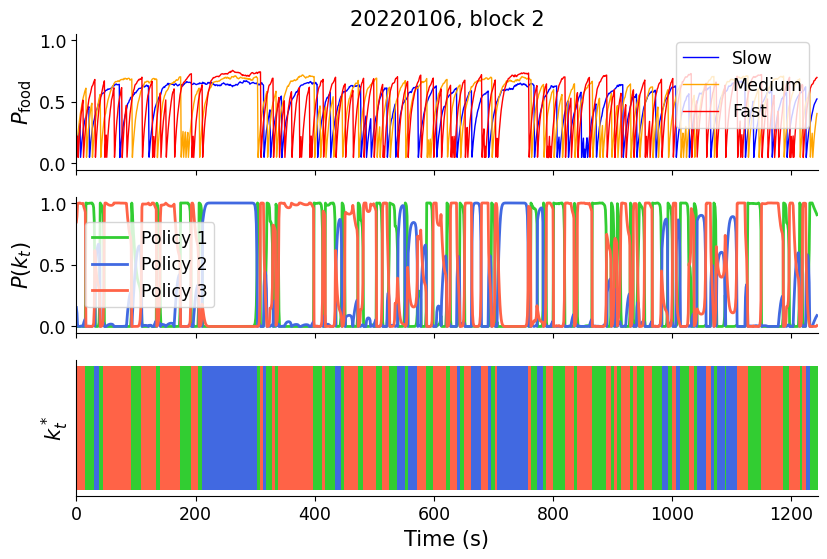

In [4]:
from matplotlib.colors import ListedColormap

kappa = 0.01
b_idx = rng.choice([i for i, block_id in enumerate(block_ids) if block_infos[block_id]['kappa']==kappa])
n_steps = len(beliefs[b_idx])
n_policies = gammas[b_idx].shape[1]
fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
cmap = ListedColormap(['limegreen', 'royalblue', 'tomato'])
for i, ax in enumerate(axes):
    if i==0:
        lines = []
        for k, color in enumerate(['blue', 'orange', 'red']):
            line, = ax.plot(beliefs[b_idx][:, k], color=color, linewidth=1)
            lines.append(line)
        ax.legend(lines, ['Slow', 'Medium', 'Fast'])
        ax.set_ylabel(r'$P_\mathrm{food}$')
    if i==1:
        lines = []
        for k, color in enumerate(cmap.colors):
            line, = ax.plot(gammas[b_idx][:, k], color=color)
            lines.append(line)
        ax.legend(lines, [f'Policy {i+1}' for i in range(n_policies)])
        ax.set_ylabel('$P(k_t)$')
    if i==2:
        ax.imshow(
            labels[b_idx][None], extent=[0, n_steps, 0, 1],
            cmap=cmap, vmin=0, vmax=n_policies-1,
        )
        ax.set_yticks([])
        ax.set_ylabel('$k^*_t$')
    ax.set_xlim([0, n_steps])
    ax.set_ylim([-0.05, 1.05])
    ax.set_aspect(n_steps/6)
axes[0].set_title('{}, block {}'.format(block_ids[b_idx][0], block_ids[b_idx][1]+1))
axes[-1].set_xlabel('Time (s)')
fig.savefig(FIG_DIR/'marco.policy.labels.svg')

# Visualize individual policies

In [5]:
import torch
from irc.hmp import HiddenMarkovPolicy

n_policies = gammas[0].shape[1]
hmp = HiddenMarkovPolicy(
    n_policies, input_dim=3, n_actions=4, policy={'num_features': [16]},
)
hmp.load_state_dict(torch.load('store/marco.hmp.state.pt'))

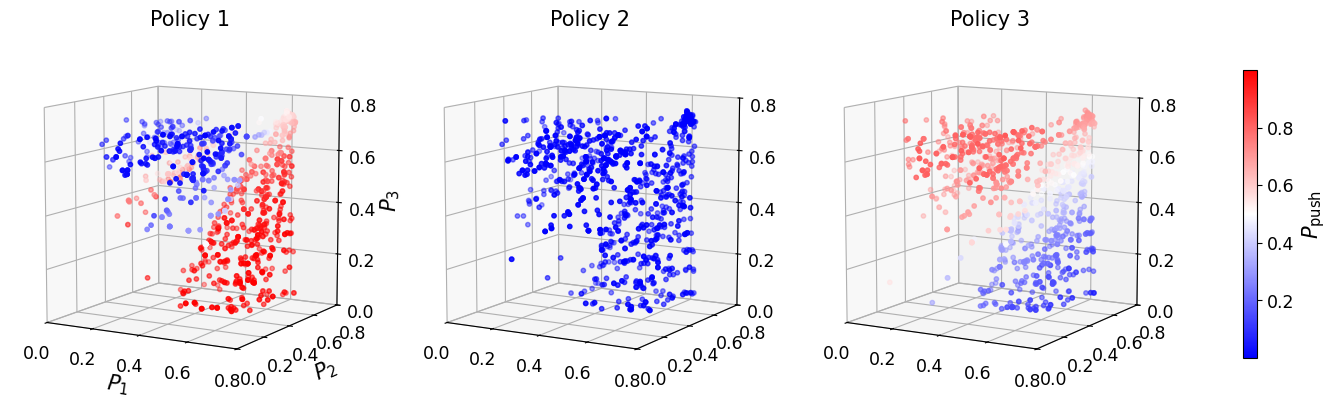

In [6]:
probs = []
for i in range(n_policies):
    with torch.no_grad():
        logits = hmp.policies[i](torch.tensor(beliefs[b_idx], dtype=torch.float))
        probs.append(1-torch.softmax(logits, dim=1)[:, 3])
probs = torch.stack(probs)

fig = plt.figure(figsize=(n_policies*5, 4))
axes = []
for i in range(n_policies):
    ax = fig.add_axes([0.025+i/n_policies, 0.05, 0.9/n_policies, 0.9], projection='3d', elev=10)
    axes.append(ax)
    idxs = rng.choice(len(beliefs[b_idx]), 1000)
    h = ax.scatter(
        beliefs[b_idx][idxs, 0], beliefs[b_idx][idxs, 1], beliefs[b_idx][idxs, 2], s=10,
        c=probs[i, idxs], cmap='bwr', vmin=probs.min(), vmax=probs.max(),
    )
    ax.set_xlim([0, 0.8]), ax.set_ylim([0, 0.8]), ax.set_zlim([0, 0.8])
    ax.set_aspect('equal')
    ax.set_title(f'Policy {i+1}')
    if i==0:
        ax.set_xlabel('$P_1$'), ax.set_ylabel('$P_2$'), ax.set_zlabel('$P_3$')
fig.colorbar(h, ax=axes, shrink=0.8, label=r'$P_\mathrm{push}$')
fig.savefig(FIG_DIR/'marco.bandit.policies.svg')